# Kaggle沃尔玛销售预测

##### 辅助函数和包

In [2]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
from math import ceil
from sklearn.preprocessing import LabelEncode
from source.memory import sizeof_fmt, get_memory_usagel, reduce_mem_usage
from source.pd_merger import merge_by_concat
from source.parallel import df_parallelize_run
warnings.filterwarnings('ignore')

##### 代码目录
![title](https://cdn.nlark.com/yuque/0/2020/png/1301375/1591948575891-db9a4654-bfd1-4bf3-aa33-433dab71c6ed.png)
> （安装jupyter插件TOC（table of content）后可跳转查看）


# 第一部分：特征工程

## 1. 建立基本特征

In [6]:
########## 定义常量 ##########
TARGET = 'sales'         # 销售预测目标列
END_TRAIN = 1913         # 训练集的最后一天
KEY_INDEX = ['id','d']   # 主键

In [7]:
########## 导入数据 ##########
print('Loading Main Data: ')
train_df = pd.read_csv('./Input/sales_train_validation.csv') # 主要时间序列面板数据
prices_df = pd.read_csv('./Input/sell_prices.csv') # 价格信息
calendar_df = pd.read_csv('./Input/calendar.csv') # 节假日信息

Loading Main Data: 


### 1.1 转换数据并减少内存消耗

In [9]:
print('Part 1: Basic transformatio: ')
index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
data_df = pd.melt(train_df, 
                  id_定义常量 = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

Part 1: Basic transformatio: 


In [ ]:
grid_test = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df[index_columns]
    temp_df = temp_df
    temp_df['d'] = 'd_'+ str(END_TRAIN+i) 
    temp_df[TARGET] = np.nan
    grid_test = pd.concat([grid_test,temp_df])

In [12]:
data_df = pd.concat([data_df,grid_test])
data_df = data_df.reset_index(drop=True) # 现在的data_df是带测试集的长数据

In [13]:
########## Remove dafaframe used up ##########
del temp_df, grid_test, train_df

In [14]:
########## 内存减小 ##########
print("{:>20}: {:>8}".format('Original data_df',sizeof_fmt(data_df.memory_usage(index=True).sum())))
# 数据转换
for col in index_columns:
    data_df[col] = data_df[col].astype('category')
print("{:>20}: {:>8}".format('Reduced data_df',sizeof_fmt(data_df.memory_usage(index=True).sum())))

    Original grid_df:   3.5GiB
     Reduced grid_df:   1.3GiB


In [15]:
########## 计算商品发售日期 ####################
# 有些训练集中的销售为0 是在产品推行之前的销量，当然是0！
release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']
data_df = merge_by_concat(data_df, release_df, ['store_id','item_id'])
del release_df

In [16]:
########## 删除未发售商品的0销量特征 ####################
data_df = merge_by_concat(data_df, calendar_df[['wm_yr_wk','d']], ['d'])
data_df = data_df[data_df['wm_yr_wk']>=data_df['release']] # 只留下周数>=发行周的
data_df = data_df.reset_index(drop=True)

print("{:>20}: {:>8}".format('Original data_df',sizeof_fmt(data_df.memory_usage(index=True).sum())))
data_df['release'] = data_df['release'] - data_df['release'].min()
data_df['release'] = data_df['release'].astype(np.int16)
print("{:>20}: {:>8}".format('Reduced data_df',sizeof_fmt(data_df.memory_usage(index=True).sum())))

    Original grid_df:   1.7GiB
     Reduced grid_df:   1.5GiB


In [17]:
################ 储存第一部分 ################
# 目前为止：data_df是一个转换为长数据、删除没必要的0销售的dataframe
print('Saving Part 1 as pickle')
data_df.to_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl')
print('Done! Size of part 1:', data_df.shape)
del data_df

Saving Part 1 as pickle
Done! Size of part 1: (46881677, 10)


### 1.2 加入价格信息

#### 1.2.1 基本价格信息

In [18]:
print('Part 2: Prices')
data_df = pd.read_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl')

Part 2: Prices


In [19]:
################ Basic aggregations ################
# 每个商品价格的基本的特征
prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# Normalization
prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

# 识别波动商品
prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
    # nunique: 每个商品有多少个不同的售价
    # prices_df.iloc[prices_df["price_nunique"].idxmax()]返回：有一个Food食品价格换了11次

# 识别常见价格设定
prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')
    # nunique: 每个售价 对应的商品有多少个
    # prices_df.iloc[prices_df["item_nunique"].idxmax()]返回：1.98元的商品有305个

#### 1.2.2 价格特征滚动聚合

In [20]:
################ Adding month/year to price_df ################ 
calendar_prices = calendar_df[['wm_yr_wk','month','year']].drop_duplicates(subset=['wm_yr_wk'])
    # 每周 —— 都有对应的月和年的信息
prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
    # 每周作为键，merge到prices_df里面，这样每个售价就有价格信息了
del calendar_prices

In [21]:
################ Add price "momentum" ################
# 可以捕捉到商品的降价、涨价信息，可能有周期性
# 当周价格/上周价格
prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))

# 当周价格/当月价格（将来的售卖是未知的，但是价格已提前确定）
prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')

# 当周价格/当年价格
prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')
del prices_df['month'], prices_df['year']

In [22]:
################ Merge prices ################
print('Merge prices')
original_columns = list(data_df) # Merge price之前的grid
data_df = data_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(data_df) if col not in original_columns]
data_df = data_df[KEY_INDEX+keep_columns]
data_df = reduce_mem_usage(data_df)  # 减小完内存后，现在的data_df有ID\D，加上所有的price信息

Merge prices
Memory usage decreased to 1789.88 Mb now, with (62.2% reduction saved)


In [23]:
################ Saving part 2 ################
print('Saving part 2')
data_df.to_pickle('./Processing/Features/Basic_FE/grid_part_2.pkl')
print('Size:', data_df.shape)

del prices_df,data_df

Saving part 2
Size: (46881677, 13)


#### 1.2.3 总结

In [24]:
################ Merge calendar ################ 
data_df = pd.read_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl')
data_df = data_df[KEY_INDEX]

In [25]:
icols = ['date',
         'd',
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']

data_df = data_df.merge(calendar_df[icols], on=['d'], how='left')

In [26]:
################ Minify data ################ 
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI'] # 'snap_' columns本来是01
for col in icols:
    data_df[col] = data_df[col].astype('category')

In [27]:
################ Date features ################ 
data_df['date'] = pd.to_datetime(data_df['date'])
data_df['tm_d'] = data_df['date'].dt.day.astype(np.int8) # tm stands for time
data_df['tm_w'] = data_df['date'].dt.week.astype(np.int8)
data_df['tm_m'] = data_df['date'].dt.month.astype(np.int8)
data_df['tm_y'] = data_df['date'].dt.year
data_df['tm_y'] = (data_df['tm_y'] - data_df['tm_y'].min()).astype(np.int8)
data_df['tm_wm'] = data_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)# 这个月的第几周
data_df['tm_dw'] = data_df['date'].dt.dayofweek.astype(np.int8) # 这个周的第几天（星期X）
data_df['tm_w_end'] = (data_df['tm_dw']>=5).astype(np.int8) # 识别周末，转为01

del data_df['date']

In [28]:
################ 存储第三部分 ################
print('Save part 3')
data_df.to_pickle('./Processing/Features/Basic_FE/grid_part_3.pkl')
print('Size:', data_df.shape)
del calendar_df
del data_df

Save part 3
Size: (46881677, 16)


In [29]:
################ 原始数据中的“d”进行转换 ################
data_df = pd.read_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl')
data_df['d'] = data_df['d'].apply(lambda x: x[2:]).astype(np.int16)

del data_df['wm_yr_wk']

data_df.to_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl')
del data_df

In [31]:
# 合并三组数据并检查内存
import pandas as pd
data_df = pd.concat([pd.read_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl'),
                     pd.read_pickle('./Processing/Features/Basic_FE/grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('./Processing/Features/Basic_FE/grid_part_3.pkl').iloc[:,2:]],
                     axis=1)
# Check memory usage
print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(data_df.memory_usage(index=True).sum())))
print('Size:', data_df.shape)

           Full Grid:   2.4GiB
Size: (46881677, 34)


In [32]:
# 第一个特征汇总
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 34 columns):
 #   Column            Dtype   
---  ------            -----   
 0   id                category
 1   item_id           category
 2   dept_id           category
 3   cat_id            category
 4   store_id          category
 5   state_id          category
 6   d                 int16   
 7   sales             float64 
 8   release           int16   
 9   sell_price        float16 
 10  price_max         float16 
 11  price_min         float16 
 12  price_std         float16 
 13  price_mean        float16 
 14  price_norm        float16 
 15  price_nunique     float16 
 16  item_nunique      int16   
 17  price_momentum    float16 
 18  price_momentum_m  float16 
 19  price_momentum_y  float16 
 20  event_name_1      category
 21  event_type_1      category
 22  event_name_2      category
 23  event_type_2      category
 24  snap_CA           category
 25  snap_TX         

## 2. 建立滞后阶特征

### 2.1 数据读取并缩小内存

In [5]:
######################### 获取数据 ##########################
train_df = pd.read_csv('./Input/sales_train_validation.csv')
train_df = train_df[train_df['state_id']=='CA']

print('Main Data Loaded')

Main Data Loaded


In [8]:
## 缩小内存
train_df['d'] = train_df['d'].apply(lambda x: x[2:]).astype(np.int16)
icols = ['id','item_id','dept_id','cat_id','store_id','state_id']
for col in icols:
    train_df[col] = train_df[col].astype('category')

### 2.2 特征提取

滞后阶特征示意图：
![title](https://cdn.nlark.com/yuque/0/2020/png/1301375/1591948972174-0173ed53-0024-4647-96fb-722913c90254.png)
Rollign特征示意图：
![title](https://cdn.nlark.com/yuque/0/2020/png/1301375/1591948972174-0173ed53-0024-4647-96fb-722913c90254.png)

In [11]:
data_df = pd.read_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl')
data_df = data_df[['id','d','sales']]
SHIFT_DAY = 28
start_time = time.time()
print('Create lags')

# 第一种lag：创建从28～28+14 的lags
LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+15)]
data_df = data_df.assign(**{
        '{}_lag_{}'.format(col, l): data_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

## Minify lag columns把lag的内存减小
for col in list(data_df):
    if 'lag' in col:
        data_df[col] = data_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# 第二种：Rollings with 28 day shift 
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,30,60,180]:
    print('Rolling period:', i)
    data_df['rolling_mean_'+str(i)] = data_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    # 先滞后28天，再rolling7，表示28前的一周数据，也就是28+7的35天前 到 28天前 的数据
    # 如果改成先滞后29天，再rolling7，表示大概一个月前 的前周数据，也就是29+7的36天前 到 29天前 的数据
    data_df['rolling_std_'+str(i)]  = data_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# 第三种：Rollings with sliding shift 

for d_shift in [1,8,15]:   ###！！！！！！！我觉得这里有问题 应该是1 8 15才对！！！！！！改了！
    print('Shifting period:', d_shift)
    for d_window in [7,14,30,60]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        ## shift1+rolling7，表示一周前七天的数据，命名为rolling_mean_tmp_1_7 
        data_df[col_name] = data_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

Create lags
8.57 min: Lags
Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 30
Rolling period: 60
Rolling period: 180
Shifting period: 1
Shifting period: 8
Shifting period: 15
46.06 min: Lags


In [13]:
########## 导出 ##########
print('Save lags and rollings')
data_df.to_pickle('./Processing/Features/Lags_FE/lags_df_'+str(SHIFT_DAY)+'.pkl')

Save lags and rollings


### 2.3 滞后特征总结

In [14]:
data_df = pd.read_pickle('./Processing/Features/Lags_FE/lags_df_28.pkl')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 40 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   id                      category
 1   d                       int16   
 2   sales                   float64 
 3   sales_lag_28            float16 
 4   sales_lag_29            float16 
 5   sales_lag_30            float16 
 6   sales_lag_31            float16 
 7   sales_lag_32            float16 
 8   sales_lag_33            float16 
 9   sales_lag_34            float16 
 10  sales_lag_35            float16 
 11  sales_lag_36            float16 
 12  sales_lag_37            float16 
 13  sales_lag_38            float16 
 14  sales_lag_39            float16 
 15  sales_lag_40            float16 
 16  sales_lag_41            float16 
 17  sales_lag_42            float16 
 18  rolling_mean_7          float16 
 19  rolling_std_7           float16 
 20  rolling_mean_14         float16 
 21  rollin

## 3. 建立聚合特征

### 3.1 数据读取

In [2]:
########## 导入第一部分的结果 ##########
data_df = pd.concat([pd.read_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl'),
                     pd.read_pickle('./Processing/Features/Basic_FE/grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('./Processing/Features/Basic_FE/grid_part_3.pkl').iloc[:,2:]],
                        # delete id and d_ in part 2 and part3
                     axis=1)
    # 这里只加入了基础的，没有加入lags的～需要在这里搜索一下！

In [3]:
########## Subsampling Data ########## 
# To make all calculations faster, keep only 10% of original ids.
keep_id = np.array_split(list(data_df['id'].unique()), 10)[0]
    # 分成10份 保留一份
data_df = data_df[data_df['id'].isin(keep_id)].reset_index(drop=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5918109 entries, 0 to 5918108
Data columns (total 34 columns):
 #   Column            Dtype   
---  ------            -----   
 0   id                category
 1   item_id           category
 2   dept_id           category
 3   cat_id            category
 4   store_id          category
 5   state_id          category
 6   d                 int16   
 7   sales             float64 
 8   release           int16   
 9   sell_price        float16 
 10  price_max         float16 
 11  price_min         float16 
 12  price_std         float16 
 13  price_mean        float16 
 14  price_norm        float16 
 15  price_nunique     float16 
 16  item_nunique      int16   
 17  price_momentum    float16 
 18  price_momentum_m  float16 
 19  price_momentum_y  float16 
 20  event_name_1      category
 21  event_type_1      category
 22  event_name_2      category
 23  event_type_2      category
 24  snap_CA           category
 25  snap_TX           

In [4]:
########## Global 定义常量 ########## 
SEED = 42             # Our random seed for everything
random.seed(SEED)     # to make all tests "deterministic"
np.random.seed(SEED)
N_CORES = psutil.cpu_count()     # Available CPU cores
TARGET = 'sales'      # Our Target
END_TRAIN = 1913      # And we will use last 28 days as validation

In [5]:
########## Baseline model ########## 
# 删除之前在part1加入的 测试集部分(天数标记1914之后的)
data_df = data_df[data_df['d']<=END_TRAIN].reset_index(drop=True)
remove_features = ['id','d',TARGET]
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',         # Standart boosting type
                    'objective': 'regression',       # Standart loss for RMSE
                    'metric': ['rmse'],              # as we will use rmse as metric "proxy"
                    'subsample': 0.8,                
                    'subsample_freq': 1,
                    'learning_rate': 0.05,           # 0.5 is "fast enough" for us
                    'num_leaves': 2**7-1,            # We will need model only for fast check
                    'min_data_in_leaf': 2**8-1,      # So we want it to train faster even with drop in generalization 
                    'feature_fraction': 0.8,
                    'n_estimators': 5000,            # We don't want to limit training (you can change 5000 to any big enough number)
                    'early_stopping_rounds': 30,     # We will stop training almost immediately (if it stops improving) 
                    'seed': SEED,
                    'verbose': -1,
                } 

def rmse(y, y_pred):
    '''
    Return RMSE to assess performance
    '''
    return np.sqrt(np.mean(np.square(y - y_pred)))

def make_fast_test(df,params=lgb_params):
    '''
    建LGB的同时，返回RMSE
    '''
    features_columns = [col for col in list(df) if col not in remove_features]
    
    # 分一个月当测试集
    tr_x, tr_y = df[df['d']<=(END_TRAIN-28)][features_columns], df[df['d']<=(END_TRAIN-28)][TARGET]              
    vl_x, vl_y = df[df['d']>(END_TRAIN-28)][features_columns], df[df['d']>(END_TRAIN-28)][TARGET]
    
    train_data = lgb.Dataset(tr_x, label = tr_y)
    valid_data = lgb.Dataset(vl_x, label = vl_y)
    
    estimator = lgb.train(  params,
                            train_data,
                            valid_sets = [train_data,valid_data],
                            verbose_eval = 500)
    return estimator

# Make baseline model
baseline_model = make_fast_test(data_df)

Training until validation scores don't improve for 30 rounds
[500]	training's rmse: 2.64503	valid_1's rmse: 2.40932
Early stopping, best iteration is:
[661]	training's rmse: 2.61187	valid_1's rmse: 2.40272


### 3.3 特征构建执行

In [16]:
########## Apply on data_df ##########
data_df = pd.read_pickle('./Processing/Features/Basic_FE/grid_part_1.pkl')
data_df[TARGET][data_df['d']>(1913-28)] = np.nan
base_cols = list(data_df)

icols =  [
            ['state_id'],
            ['store_id'],
            ['cat_id'],
            ['dept_id'],
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
            ]

for col in icols:
    print('Encoding', col)
    col_name = '_'+'_'.join(col)+'_'
    data_df['enc'+col_name+'mean'] = data_df.groupby(col)[TARGET].transform('mean').astype(np.float16)
    data_df['enc'+col_name+'std'] = data_df.groupby(col)[TARGET].transform('std').astype(np.float16)

keep_cols = [col for col in list(data_df) if col not in base_cols]
data_df = data_df[['id','d']+keep_cols]

Encoding ['state_id']
Encoding ['store_id']
Encoding ['cat_id']
Encoding ['dept_id']
Encoding ['state_id', 'cat_id']
Encoding ['state_id', 'dept_id']
Encoding ['store_id', 'cat_id']
Encoding ['store_id', 'dept_id']
Encoding ['item_id']
Encoding ['item_id', 'state_id']
Encoding ['item_id', 'store_id']


In [17]:
print('Save Mean/Std encoding')
data_df.to_pickle('./Processing/Features/Combined_FE/mean_encoding_df.pkl')

Save Mean/Std encoding


In [18]:
########## Summary ##########
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46881677 entries, 0 to 46881676
Data columns (total 24 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   id                         category
 1   d                          int16   
 2   enc_state_id_mean          float16 
 3   enc_state_id_std           float16 
 4   enc_store_id_mean          float16 
 5   enc_store_id_std           float16 
 6   enc_cat_id_mean            float16 
 7   enc_cat_id_std             float16 
 8   enc_dept_id_mean           float16 
 9   enc_dept_id_std            float16 
 10  enc_state_id_cat_id_mean   float16 
 11  enc_state_id_cat_id_std    float16 
 12  enc_state_id_dept_id_mean  float16 
 13  enc_state_id_dept_id_std   float16 
 14  enc_store_id_cat_id_mean   float16 
 15  enc_store_id_cat_id_std    float16 
 16  enc_store_id_dept_id_mean  float16 
 17  enc_store_id_dept_id_std   float16 
 18  enc_item_id_mean           float16 
 19  enc_item_id_std    

## 4. 特征筛选

> 这里主要使用了permutation importance test和LOFO test来进行变量选择, 后面尝试了一下PCA但是效果一般
> - **4.1 permutation importance test:** 把一个特征里的数值全部随机打乱，如果模型效果下降很多说明该特征比较重要，如果模型效果没有下降或者反而提升，说明这个特征不重要或者本来就是noise！
> - **4.2 LOFO test:** LOFO (Leave One Feature Out) Importance calculates the importances of a set of features based on a metric of choice, for a model of choice, by iteratively removing each feature from the set, and evaluating the performance of the model, with a validation scheme of choice, based on the chosen metric.
>  - https://pypi.org/project/lofo-importance/

### 4.1 Permutation importance test

#### 4.1.1 滞后阶特征验证

##### Lags (7 days):

In [6]:
from multiprocessing import Pool 

def df_parallelize_run(func, t_split):
    '''
    一个类似于一个用多线程写出的apply方法，第一个是处理单个lag的方程，第二个是lags的列表
    注意：This function is NOT 'bulletproof', be carefull and pass only correct types of variables.
    :t_split - int of lags days                   # type: int
    :func - Function to apply on each split       # type: python function
    '''
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

def make_lag(lag_day):
    lag_df = data_df[['id','d',TARGET]] 
        # 这里的data_df是全局操作的时候，不断改变的量，会从环境中获取当前的
    col_name = 'sales_lag_'+str(lag_day)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(lag_day)).astype(np.float16)
        # 将每个id的销售shift一个lag—_day，然后保存为column
    return lag_df[[col_name]]

LAGS_SPLIT = [col for col in range(1,1+7)]
data_df = pd.concat([data_df, df_parallelize_run(make_lag,LAGS_SPLIT)], axis=1)
test_model = make_fast_test(data_df)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[431]	training's rmse: 2.42907	valid_1's rmse: 2.24745


##### 运行 Permutation importance Test：

In [7]:
# Creat validation dataset and features
validation_df = data_df[data_df['d']>(END_TRAIN-28)].reset_index(drop=True)

# Make normal prediction with our model and save score
features_columns = [col for col in list(data_df) if col not in remove_features]
validation_df['preds'] = test_model.predict(validation_df[features_columns])
base_score = rmse(validation_df[TARGET], validation_df['preds'])
print('Base RMSE:', base_score)

# Looping over all numerical features
for col in features_columns:
    # Make validation set copy to restore features on each run
    temp_df = validation_df.copy() 
    
    if temp_df[col].dtypes.name != 'category': # Check if feature is numerical
        # Step1: 把原来validation_df中的col特征打乱
        temp_df[col] = np.random.permutation(temp_df[col].values)
        
        # Step2: 做出预测
        temp_df['preds'] = test_model.predict(temp_df[features_columns])
        
        # Step3: 计算新预测的得分
        cur_score = rmse(temp_df[TARGET], temp_df['preds'])
        
        # Step4: 如果打乱之后，RMSE应该会变高！如果rmse反而变低了，说明这个Feature本来就不怎么样
        print("Adding",col,":", np.round(cur_score - base_score, 4))
del temp_df, validation_df

Base RMSE: 2.2474524076045217
Adding release : 0.0
Adding sell_price : 0.0048
Adding price_max : 0.0007
Adding price_min : 0.0001
Adding price_std : 0.0002
Adding price_mean : 0.0004
Adding price_norm : 0.0007
Adding price_nunique : 0.0005
Adding item_nunique : 0.0011
Adding price_momentum : 0.0001
Adding price_momentum_m : 0.0035
Adding price_momentum_y : 0.0003
Adding tm_d : -0.0003
Adding tm_w : 0.0001
Adding tm_m : 0.0001
Adding tm_y : 0.0
Adding tm_wm : 0.0002
Adding tm_dw : 0.1191
Adding tm_w_end : 0.0038
Adding sales_lag_1 : 0.348
Adding sales_lag_2 : 0.0284
Adding sales_lag_3 : 0.0103
Adding sales_lag_4 : 0.0129
Adding sales_lag_5 : 0.0121
Adding sales_lag_6 : 0.0182
Adding sales_lag_7 : 0.0353


##### Lags far away:

In [9]:
# 移除刚刚加入的一周的lags
keep_cols = [col for col in list(data_df) if 'sales_lag_' not in col]
data_df = data_df[keep_cols]

# 选择8周前（大概两个月前）的一周数据+目前的最近1周数据建模
LAGS_SPLIT = [col for col in range(56,56+7)]
data_df = pd.concat([data_df, df_parallelize_run(make_lag,LAGS_SPLIT)], axis=1)
test_model = make_fast_test(data_df)

# 计算基础的RMSE
features_columns = [col for col in list(data_df) if col not in remove_features]
validation_df = data_df[data_df['d']>(END_TRAIN-28)].reset_index(drop=True)
validation_df['preds'] = test_model.predict(validation_df[features_columns])
base_score = rmse(validation_df[TARGET], validation_df['preds'])
print('Base RMSE:', base_score)

# 计算far lags和其他变量的RMSE
for col in features_columns:
    temp_df = validation_df.copy()
    if temp_df[col].dtypes.name != 'category':
        temp_df[col] = np.random.permutation(temp_df[col].values)
        temp_df['preds'] = test_model.predict(temp_df[features_columns])
        cur_score = rmse(temp_df[TARGET], temp_df['preds'])
        print(col, np.round(cur_score - base_score, 4))

del temp_df, validation_df
        
# Remove current test features
keep_cols = [col for col in list(data_df) if 'sales_lag_' not in col]
data_df = data_df[keep_cols]

# Results:
## Lags with 56 days shift (far away past) are not as important
## as nearest past lags
## and at some point will be just noise for our model

## 因此 这就是为什么 之前的不用56天+的～

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[447]	training's rmse: 2.64849	valid_1's rmse: 2.40496
Base RMSE: 2.404958886351663
release 0.0
sell_price 0.0039
price_max 0.0037
price_min 0.0016
price_std 0.0043
price_mean 0.005
price_norm 0.0019
price_nunique 0.0057
item_nunique 0.0073
price_momentum 0.004
price_momentum_m 0.0311
price_momentum_y 0.0037
tm_d 0.0027
tm_w 0.0024
tm_m 0.0016
tm_y 0.0
tm_wm -0.0001
tm_dw 0.1241
tm_w_end 0.0056
sales_lag_56 0.0225
sales_lag_57 0.0162
sales_lag_58 0.0064
sales_lag_59 0.0047
sales_lag_60 0.0047
sales_lag_61 0.0051
sales_lag_62 0.0142


#### 4.1.2 Mean encodings Mean/std

In [14]:
########## Mean/std target encoding ##########

# We will use these three columns for test in combination with store_id
icols = ['item_id','cat_id','dept_id']

for col in icols:
    print('Encoding', col)
    temp_df = data_df[data_df['d']<=(1913-28)] # to be sure we don't have leakage in our validation set
    
    temp_df = temp_df.groupby([col,'store_id']).agg({TARGET: ['std','mean']})
        # 不同分层信息与商店进行组合，然后计算均值和标准差
        
    # Name the columns
    joiner = '_'+col+'_encoding_'
    temp_df.columns = [joiner.join(col).strip() for col in temp_df.columns.values]
    temp_df = temp_df.reset_index()
    
    data_df = data_df.merge(temp_df, on=[col,'store_id'], how='left')
    del temp_df

# Make features test
test_model = make_fast_test(data_df)

# Remove test features
keep_cols = [col for col in list(data_df) if '_encoding_' not in col]
data_df = data_df[keep_cols]

Encoding item_id
Encoding cat_id
Encoding dept_id
Training until validation scores don't improve for 30 rounds
[500]	training's rmse: 2.61617	valid_1's rmse: 2.39825
Early stopping, best iteration is:
[805]	training's rmse: 2.56027	valid_1's rmse: 2.3828


##### 4.1.3 结果

![title](
https://cdn.nlark.com/yuque/0/2020/png/1301375/1589447430825-13049e8c-6567-4893-a81b-ed13993e17a3.png?x-oss-process=image%2Fresize%2Cw_944)

- 汇总以上的结果，可以看到tm_dw（一周的第几天）是最重要的，因为shuffle它的值之后RMSE下降最多，而price_momentum_y（年度涨价幅度）等特征没有什么用，应该在后续删除掉

### 4.2 LOFO test

#### 4.2.1 进行LOFO检测

In [35]:
# !pip3 install lofo
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold

In [36]:
def transform(data):
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
    
    data['id_encode'], _ = data["id"].factorize()
    
    cat = ['item_id', 'dept_id', 'cat_id',  'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        data[feature], _ = data[feature].factorize()
    
    return data

In [ ]:
# LOFO检测
for store_id in STORES_IDS:

  print('select features for: ', store_id)
  # 得到每个商店的数据并整理
  grid_df, features_columns = get_data_by_store(store_id)
  sample_df = grid_df.sample(frac=0.01, random_state=random_state)
  sample_df.sort_values("d", inplace=True)  

  # 转换成category
  sample_df[CAT_FEA] = sample_df[CAT_FEA].astype('object')
  sample_df = transform(sample_df)
  sample_df[CAT_FEA] = sample_df[CAT_FEA].astype('category')
  features_columns.append('id_encode')
  sample_df.dropna(inplace=True)
  dataset = Dataset(df=sample_df, target="sales", features=features_columns)
  cv = KFold(n_splits=5, shuffle=False, random_state=0)

  # LOFO检测
  lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_squared_error")

  # 输出结果
  importance_df = lofo_imp.get_importance()
  pd.to_pickle(importance_df,'data/importancedf_'+str(random_state)+'_'+store_id+'.pkl')

select features for:  CA_1



select features for:  CA_2



select features for:  CA_3



select features for:  TX_1



select features for:  TX_2



select features for:  TX_3



select features for:  WI_1



select features for:  WI_2



select features for:  WI_3


#### 4.2.2 结果汇总

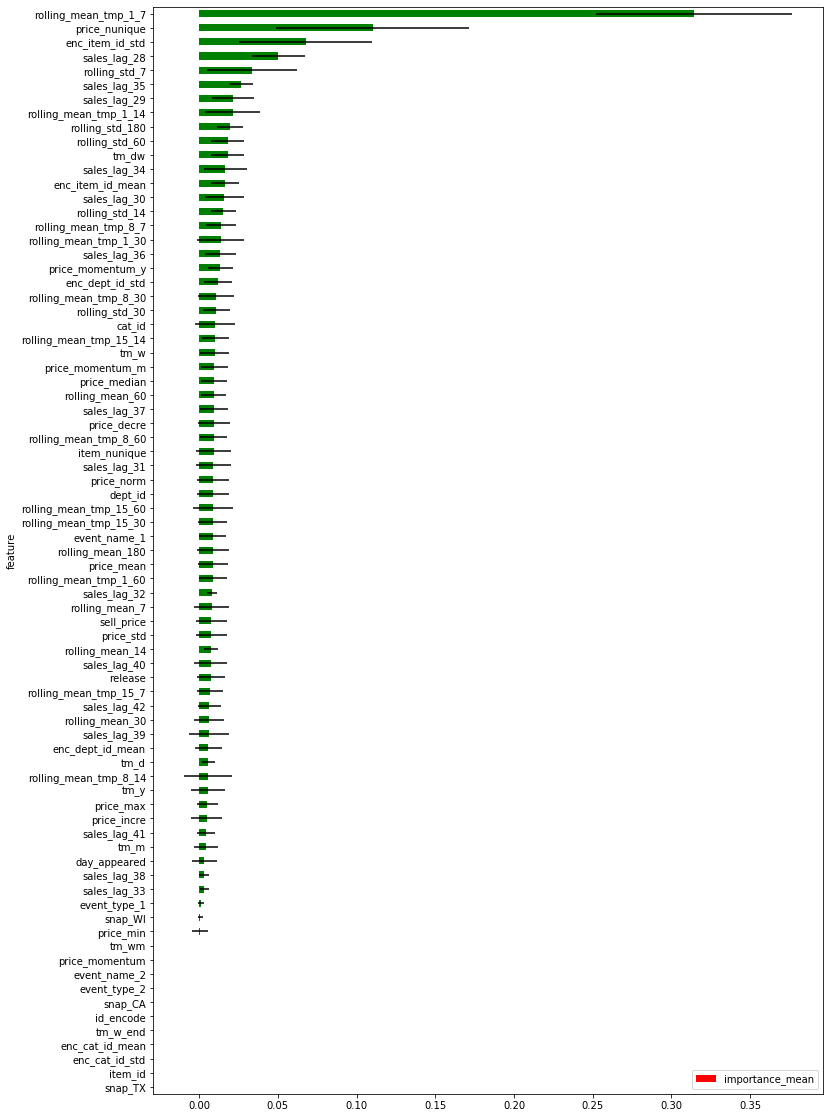

In [46]:
# CA_3在随机数种子0下：
import pickle
import matplotlib.pyplot as plt
importance_df = pd.read_pickle("./Processing/Features_tested/importancedf_0_CA_3.pkl")
plot_importance(importance_df, figsize=(12, 20))

- 可以看到，在California洲三号商店，几乎所有的变量删除之后效果都下降了，说明对模型是正向作用，只有10个变量删除之后效果不变

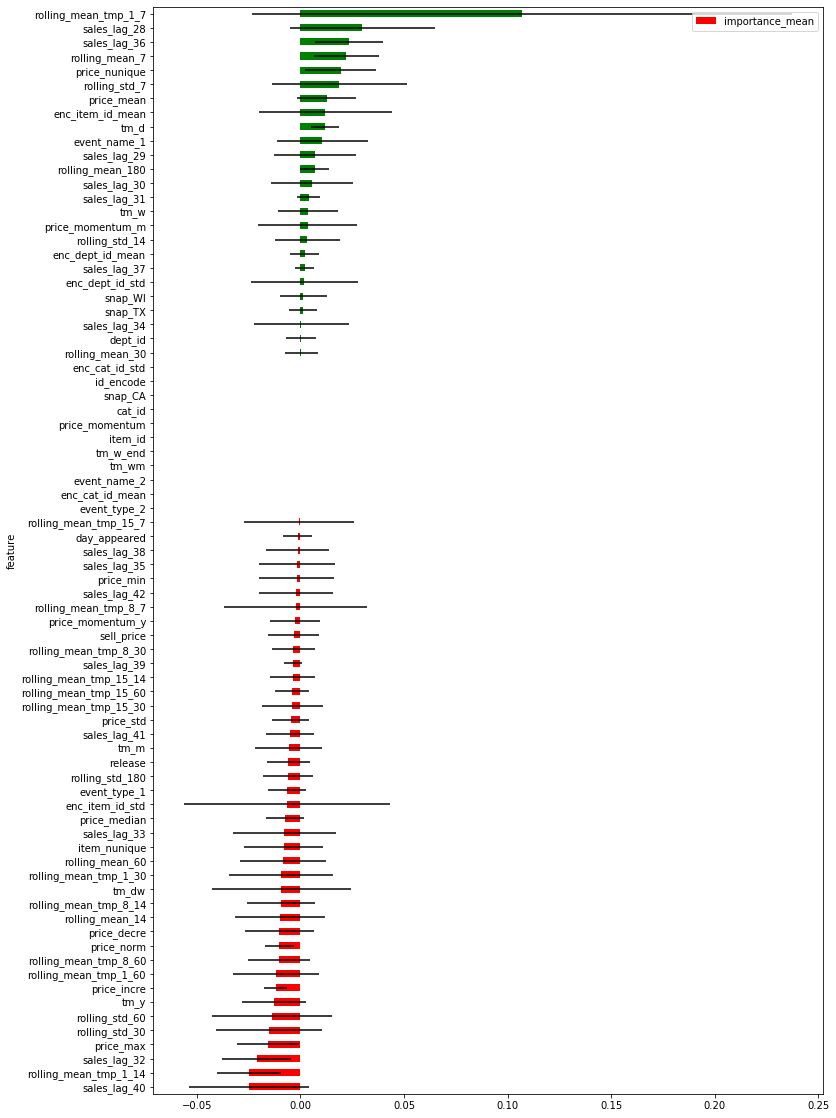

In [45]:
importance_df = pd.read_pickle("./Processing/Features_tested/importancedf_0_CA_1.pkl")
plot_importance(importance_df, figsize=(12, 20))

- 然而，在California洲一号商店，大部分的变量是有害的，不到一半有效，因此预示着我们应该对每一个商店选择不同的特征进行建模！

### 4.3 PCA降唯 

In [10]:
# 尝试将lag1——7组合成pca，看看能不能得到几乎相同的rmse
from sklearn.decomposition import PCA
def make_pca(df, pca_col, n_days):
    '''
    Try PCA and make 7->3 dimensionality reduction
    :df - 整体数据
    :pca_col - 设置成id, 表示需要到多基本的数据框
    :n_days - if = 7, 表示会生成滞后7天的lags 并从中选择3个主成分
    '''
    print('PCA on:', pca_col, n_days)
    pca_df = df[[pca_col,'d',TARGET]]
        # 需要pca的col, d用于定位, 目标变量 就可以了
        
    # If we are doing pca for other series "levels", we need to agg first
    if pca_col != 'id':
        merge_base = pca_df[[pca_col,'d']] #去掉target的基本base
        pca_df = pca_df.groupby([pca_col,'d'])[TARGET].agg(['sum']).reset_index()
        pca_df[TARGET] = pca_df['sum']
        del pca_df['sum']
    
    # Min/Max scaling
    pca_df[TARGET] = pca_df[TARGET]/pca_df[TARGET].max()
    
    # Making "lag"
    LAG_DAYS = [col for col in range(1,n_days+1)]
    format_str = '{}_pca_'+pca_col+str(n_days)+'_{}'
    pca_df = pca_df.assign(**{
            format_str.format(target, lag): pca_df.groupby([pca_col])[target].transform(lambda x: x.shift(lag))
            for lag in LAG_DAYS
            for target in [TARGET]
        })
    
    # 对需要进行pca的列清洗数据
    pca_columns = list(pca_df)[3:] # pca_df前三列是id d 和target
    pca_df[pca_columns] = pca_df[pca_columns].fillna(0)
    
    # Fit PCA
    pca = PCA(random_state=SEED)    
    pca.fit(pca_df[pca_columns])
    pca_df[pca_columns] = pca.transform(pca_df[pca_columns])
    print(pca.explained_variance_ratio_)
    
    # Keep only 3 most "valuable" columns/dimensions 
    keep_cols = pca_columns[:3]
    print('Columns to keep:', keep_cols)
    
    # 备注：如果pca的对象不是id的话，要先把结果加起来，然后merge到merge_base
    return pca_df[keep_cols]

In [11]:
data_df = pd.concat([data_df, make_pca(data_df,'id',7)], axis=1)

PCA on: id 7
[0.70477166 0.06805795 0.06137376 0.04555803 0.04232764 0.0394055
 0.03850546]
Columns to keep: ['sales_pca_id7_1', 'sales_pca_id7_2', 'sales_pca_id7_3']


In [12]:
# 结果：
test_model = make_fast_test(data_df)

Training until validation scores don't improve for 30 rounds
[500]	training's rmse: 2.46387	valid_1's rmse: 2.26436
Early stopping, best iteration is:
[668]	training's rmse: 2.43415	valid_1's rmse: 2.26073


# 第二部分 模型训练

#### 1. 辅助函数

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

# 多线程运行（用于后面同时滞后阶）
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

def get_data_by_store(store):
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # 只使用其中的一个商店建模
    df = df[df['store_id']==store]
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2
    
    df = pd.concat([df, df3], axis=1)
    del df3
    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

#### 2.模型训练

In [3]:
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

In [4]:
########## 定义常量 ##########
VER = 1                          
SEED = 42                        
seed_everything(SEED)            
lgb_params['seed'] = SEED        
N_CORES = psutil.cpu_count() # 获取可以使用的CPU个数，方便操作


TARGET      = 'sales'            
START_TRAIN = 0                  
END_TRAIN   = 1913               
P_HORIZON   = 28                 
USE_AUX     = False              

remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
ORIGINAL = './Input/'
BASE     = './Processing/Features/Basic_FE/grid_part_1.pkl'
PRICE    = './Processing/Features/Basic_FE/grid_part_2.pkl'
CALENDAR = './Processing/Features/Basic_FE/grid_part_3.pkl'
LAGS     = './Processing/Features/Lags_FE/lags_df_28.pkl'
MEAN_ENC = './Processing/Features/Combined_FE/mean_encoding_df.pkl'
AUX_MODELS = './Processing/Pretrained_models/'


STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,8,15]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

所有特征信息：

In [9]:
data_df, features_columns = get_data_by_store("TX_1")
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797955 entries, 0 to 4797954
Data columns (total 75 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   id                      category
 1   d                       int16   
 2   sales                   float64 
 3   item_id                 category
 4   dept_id                 category
 5   cat_id                  category
 6   release                 int16   
 7   sell_price              float16 
 8   price_max               float16 
 9   price_min               float16 
 10  price_std               float16 
 11  price_mean              float16 
 12  price_norm              float16 
 13  price_nunique           float16 
 14  item_nunique            int16   
 15  price_momentum          float16 
 16  price_momentum_m        float16 
 17  price_momentum_y        float16 
 18  event_name_1            category
 19  event_type_1            category
 20  event_name_2            category
 21  event_ty

In [12]:
########## 训练模型 ##########
WORKING = './Processing/Working_trained_models/'
if USE_AUX:
    lgb_params['n_estimators'] = 2
    

main_time = time.time()
# for store_id in STORES_IDS:  ————由于每个商店训练都要接近1个小时，因此分批进行
# 第一批：for store_id in ["CA_1"]:
# 第二批：for store_id in ["CA_2","CA_3","CA_4"]:
# 第三批：for store_id in ["TX_2","TX_3","WI_1"]:
# 第四批：
for store_id in ["WI_2","WI_3"]:
    print('Train', store_id)
    start_time = time.time()
    data_df, features_columns = get_data_by_store(store_id)
    train_mask = data_df['d']<=END_TRAIN
    valid_mask = train_mask&(data_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = data_df['d']>(END_TRAIN-100)
    
    train_data = lgb.Dataset(data_df[train_mask][features_columns], 
                       label=data_df[train_mask][TARGET])
    train_data.save_binary(WORKING+'train_data.bin')
    train_data = lgb.Dataset(WORKING+'train_data.bin')
    valid_data = lgb.Dataset(data_df[valid_mask][features_columns], 
                       label=data_df[valid_mask][TARGET])

    data_df = data_df[preds_mask].reset_index(drop=True)
    keep_cols = [col for col in list(data_df) if '_tmp_' not in col]
    data_df = data_df[keep_cols]
    data_df.to_pickle(WORKING+'test_'+store_id+'.pkl')
    del data_df
    
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,
                          train_data,
                          valid_sets = [valid_data],
                          verbose_eval = 100,
                          )
    
    model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
    pickle.dump(estimator, open(WORKING+model_name, 'wb'))

    
    os.remove(WORKING+'train_data.bin')
    del train_data, valid_data, estimator
    gc.collect()
    
    MODEL_FEATURES = features_columns
    print('#'*5,"训练",store_id,'#'*5)
    print('用时',  ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60))

Train WI_2
[100]	valid_0's rmse: 2.6931
[200]	valid_0's rmse: 2.5883
[300]	valid_0's rmse: 2.55299
[400]	valid_0's rmse: 2.52937
[500]	valid_0's rmse: 2.51094
[600]	valid_0's rmse: 2.49531
[700]	valid_0's rmse: 2.48019
[800]	valid_0's rmse: 2.46357
[900]	valid_0's rmse: 2.45136
[1000]	valid_0's rmse: 2.4381
[1100]	valid_0's rmse: 2.42752
[1200]	valid_0's rmse: 2.41693
[1300]	valid_0's rmse: 2.40717
[1400]	valid_0's rmse: 2.39861
##### 训练 WI_2 #####
用时  22.82 min round |  22.82 min total |
Train WI_3
[100]	valid_0's rmse: 1.92421
[200]	valid_0's rmse: 1.85264
[300]	valid_0's rmse: 1.83094
[400]	valid_0's rmse: 1.81917
[500]	valid_0's rmse: 1.80916
[600]	valid_0's rmse: 1.80237
[700]	valid_0's rmse: 1.79451
[800]	valid_0's rmse: 1.78887
[900]	valid_0's rmse: 1.78213
[1000]	valid_0's rmse: 1.77683
[1100]	valid_0's rmse: 1.77106
[1200]	valid_0's rmse: 1.76698
[1300]	valid_0's rmse: 1.76049
[1400]	valid_0's rmse: 1.75727
##### 训练 WI_3 #####
用时  22.74 min round |  45.56 min total |


### 3. 结果
把所有数据加总起来，得到training set + validaiton set的结果：

![title](https://cdn.nlark.com/yuque/0/2020/png/1301375/1591949170631-1b80b27b-d8fa-426e-8338-b4aa47e988d8.png)

# 第三部分 预测

> 这部分是对未来28天做出新的预测（目前还不知道真实数据，只会在我们提交结果后返回一个大概的RMSE分数）

In [13]:
########## Predict ##########
all_preds = pd.DataFrame()

# 把无标签的测试集 和 最后100天的训练集连接起来，因为需要make recursive features
def get_base_test():
    base_test = pd.DataFrame()
    for store_id in STORES_IDS:
        if USE_AUX:
            temp_df = pd.read_pickle('./Processing/Pretrained_models/'+'test_'+store_id+'.pkl')
        else:
            # 建立完模型之后，对每个storeID会会保存100天的数据
            temp_df = pd.read_pickle('./Processing/Working_trained_models/'+'test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        # 每个商店100天连接起来
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    return base_test

base_test = get_base_test()

# 进一步Make dynamic rolling lags
def make_lag(LAG_DAY):
    '''
    对base_test进行滞后处理
    :LAG_DAY - 滞后的天数
    '''
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]

def make_lag_roll(LAG_DAY):
    '''
    对base_test进行滞后处理
    :LAG_DAY - [滞后的天数, 进行rolling window的天数]
    '''
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

main_time = time.time()

for PREDICT_DAY in range(1,29):    
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    # Make temporary grid to calculate rolling lags
    data_df = base_test.copy()
    data_df = pd.concat([data_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)
        # 这里的make_lag_roll对100天+28天的数据进行处理，产生了最后28天的数据标签（因为没有lag1～28所以fine）
        
    for store_id in STORES_IDS:
        model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
        if USE_AUX:
            model_path = AUX_MODELS + model_name
        else:
            model_path = WORKING + model_name
        
        estimator = pickle.load(open(model_path, 'rb'))
        
        day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
        store_mask = base_test['store_id']==store_id
        
        mask = (day_mask)&(store_mask)
        base_test[TARGET][mask] = estimator.predict(data_df[mask][MODEL_FEATURES])
    
    temp_df = base_test[day_mask][['id',TARGET]]
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)
all_preds

Predict | Day: 1
##########  1.42 min round |  1.42 min total |  37171.39 day sales |
Predict | Day: 2
##########  1.47 min round |  2.90 min total |  35328.36 day sales |
Predict | Day: 3
##########  1.65 min round |  4.54 min total |  34808.64 day sales |
Predict | Day: 4
##########  1.73 min round |  6.27 min total |  35293.22 day sales |
Predict | Day: 5
##########  1.53 min round |  7.80 min total |  41625.95 day sales |
Predict | Day: 6
##########  1.49 min round |  9.28 min total |  51069.95 day sales |
Predict | Day: 7
##########  1.40 min round |  10.68 min total |  53167.26 day sales |
Predict | Day: 8
##########  1.38 min round |  12.06 min total |  44445.42 day sales |
Predict | Day: 9
##########  1.41 min round |  13.48 min total |  44473.51 day sales |
Predict | Day: 10
##########  1.40 min round |  14.87 min total |  38937.51 day sales |
Predict | Day: 11
##########  1.47 min round |  16.34 min total |  40953.07 day sales |
Predict | Day: 12
##########  1.42 min round | 

id        F1        F2        F3        F4  \
0      HOBBIES_1_001_CA_1_validation  0.792804  0.749672  0.752070  0.772603   
1      HOBBIES_1_002_CA_1_validation  0.191488  0.193179  0.187152  0.208578   
2      HOBBIES_1_003_CA_1_validation  0.379940  0.368240  0.363692  0.365548   
3      HOBBIES_1_004_CA_1_validation  1.637411  1.349495  1.422994  1.592425   
4      HOBBIES_1_005_CA_1_validation  0.891737  0.808944  0.868869  0.914458   
...                              ...       ...       ...       ...       ...   
30485    FOODS_3_823_WI_3_validation  0.468457  0.366118  0.377015  0.355935   
30486    FOODS_3_824_WI_3_validation  0.298697  0.260727  0.270434  0.259647   
30487    FOODS_3_825_WI_3_validation  0.691676  0.581810  0.508487  0.499157   
30488    FOODS_3_826_WI_3_validation  0.986866  0.991383  0.802164  0.772970   
30489    FOODS_3_827_WI_3_validation  0.212111  1.325666  1.681337  2.166726   

             F5        F6        F7        F8        F9  ...       F19  \
0      0.948799  1.088926  1.094505  0.801494  0.840225  ...  0.806219   
1      0.233912  0.336325  0.331070  0.251728  0.239364  ...  0.215188   
2      0.552073  0.714680  0.707287  0.463409  0.443078  ...  0.544252   
3      1.835404  2.931873  3.160227  1.656267  1.463258  ...  1.955177   
4      1.180418  1.528721  1.545139  1.043787  1.022665  ...  1.117353   
...         ...       ...       ...       ...       ...  ...       ...   
30485  0.470284  0.480894  0.504204  0.544415  0.564110  ...  0.442472   
30486  0.289540  0.347416  0.353390  0.375718  0.360009  ...  0.313614   
30487  0.633478  0.737460  0.830546  1.174334  1.168332  ...  0.977514   
30488  0.872128  1.176478  1.058909  1.123743  1.165685  ...  1.056986   
30489  2.319908  2.745114  2.402642  2.528642  2.637379  ...  1.873912   

            F20       F21       F22       F23       F24       F25       F26  \
0      1.036667  1.020917  0.861781  0.777121  0.748128  0.829500  0.919716   
1      0.257768  0.270603  0.196679  0.181287  0.193799  0.216968  0.204213   
2      0.723599  0.696615  0.472421  0.415346  0.428760  0.440484  0.576813   
3      2.583192  3.128522  1.611140  1.439327  1.356890  1.376622  1.994211   
4      1.619810  1.623851  0.975397  0.870023  0.903613  0.925429  1.154709   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.585208  0.658194  0.464278  0.410157  0.406897  0.343982  0.403891   
30486  0.416405  0.487685  0.346969  0.283630  0.281423  0.264558  0.270870   
30487  1.282231  1.530529  1.123949  0.805839  0.687782  0.653544  0.713731   
30488  1.312054  1.309679  0.944712  0.835693  0.854994  0.773563  0.970022   
30489  2.683123  2.613914  1.878464  1.799750  1.647260  1.501046  1.866244   

            F27       F28  
0      1.113970  0.972772  
1      0.262657  0.257018  
2      0.706849  0.684763  
3      3.013912  3.438066  
4      1.554228  1.544786  
...         ...       ...  
30485  0.461469  0.528564  
30486  0.332772  0.310542  
30487  0.913368  0.858266  
30488  1.009741  1.185694  
30489  2.322371  2.219973  

[30490 rows x 29 columns]

In [14]:
########## Export ##########
VER = 11 #版本代号
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')[['id']]
submission = submission.merge(all_preds, on=['id'], how='left').fillna(0)
submission.to_csv('./Output/'+'submission_v'+str(VER)+'.csv', index=False)

# 结果及讨论

截止到作业提交前一周，团队现在在3095只队伍中排名293（位于top10%的铜牌区）

![title](https://cdn.nlark.com/yuque/0/2020/png/1301375/1589449333453-a853bc74-c2b4-4ddd-82f4-49102f18995e.png)

> 然而，现在排名还在每天变动，我会在6月30日比赛截止之前继续努力，**接下来的几个方向：**
1. **模型细化**: 当前模型是最小到每个商店建模，但其实基于商店里的每个商品都有自己的时间序列模式，如果对整体你和之后，再blend一些时间序列的SARIMA模型处理残差，有可能会提升结果
2. **整体上blending多个模型**: 简单尝试发现，LSTM效果虽然不如LightGBM，但是对某些地区有效
3. **识别出商品缺货特征**: 有时候商品销量为0，不是因为没有人买而是卖完了，如果我们能判断一件商品的缺货模式，而识别出测试集中商品正好在缺货状态，就可以直接给出0预测
4. **加入天气特征**: 天气会是影响人们出门购买的重要因素，但是这部分数据比赛方没有提供，而且数据量很大，需要购买服务器资源才能进行

结束语：感谢老师这学期精彩的教授让我入门了数据科学并发现了自己的兴趣，并且推荐信协助了我申请。希望自己可以在这次比赛中继续努力取得好成绩，并努力申请研究生、扎实理论、多写代码，一步步走上自己规划的数据科学的职业道路。